# Homework 4

In this homework you will get experience with Q-learning applied to some classic domains from the early literature on reinforcement learning.  You'll implement tabular Q-learning, in which the states and actions must be discrete.  The underlying domains have discrete action spaces but continuous observation spaces.  I've provided code that will convert continuous observations into discrete ones.  In a later homework we'll use neural networks to solve these same problems without the need to discretize.

## Task 1: Set up your environment

<b>There is nothing to turn in for this task.</b>

You'll need to pip install the following packages:
* gymnasium[classic-control] - a collection of RL domains
* tqdm - a tool for monitoring the progress of loops that run a long time
* numpy - a collection of useful tools for "mathy" things
* matplotlib - a collection of plotting utilities

In [141]:
!pip install gymnasium[classic-control]
!pip install --upgrade pip
!pip install gymnasium[box2d]
!pip install matplotlib
!pip install tqdm
!pip install swig

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-win_amd64.whl size=451775 sha256=6f0f32aa9af55f1e6189b37ebe39e5feaa50ecb31d2bd4e857345f4a38460aad
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\2a\e9\60\774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [103]:
import gymnasium as gym
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

## Task 2: Look at the gymnasium documentation

<b>There is nothing to turn in for this task.</b>

Gymnasium is a package that has a uniform interface to a variety of domains where RL can be used.  If your code works for one of them, it will (in theory) work for all of them.  The top-level documentation is here:

https://gymnasium.farama.org/index.html

We'll work with 3 domains.  Read the documentation for each of them:
* Mountain car - https://gymnasium.farama.org/environments/classic_control/mountain_car/
* Acrobot - https://gymnasium.farama.org/environments/classic_control/acrobot/
* Lunar lander - https://gymnasium.farama.org/environments/box2d/lunar_lander/


Each of the domains produces observations that are vectors of real values.  For example, as the documentation for the Mountain Car domain says the state has two real values:
* The position of the car on the x axis
* The velocity of the car

The class below converts real-valued vectors into discrete values.  You will experiment with the impacts of using coarse or fine discretization.  To turn a given observation that is a real-valued vector into a discrete state, the class below divides the range of each variable into a set of uniformly sized, non-overlapping bins.

For example, for the Mountain Car the smallest and largest values of x are -1.2 and 0.6, respectively.  If you select 5 bins, the size of each bin will be (0.6 - -1.2)/5 = 0.36.  They span the following ranges, which get mapped to distinct integers as shown below:
* [-1.2, -0.84) -> 0
* [-0.84, -0.48) -> 1
* [-0.48, -0.12) -> 2
* [-0.12, 0.24) -> 3
* [0.24, 0.6] -> 4

Each element of an observation gets mapped like this, and the resulting string of digits becomes a key to map to the corresponding discrete state.  Each time a new key is found (i.e., the system finds itself in a discrete state that it has never seen before) it is mapped to an integer that can be used to index into the Q-table.

Note that when the number of bins is small, the system treats lots of underlying observations as the same state.  When the number of bins is large, the system can make more fine distinctions but the Q-table gets to be large and you'll need more experience in the domain to learn about all of those states.  You will explore that tradeoff below.

In [104]:
# Let's look at an observation in the mountain car domain
env = gym.make("MountainCar-v0", render_mode=None)
observation, info = env.reset()
observation

array([-0.47075385,  0.        ], dtype=float32)

In [105]:
class Discrete:

    def __init__(self, env, nbins):
        """
        Arguments:
          env - A Gymnasium environment that was created by a call to gym.make()
          nbins - If this is an integer, then each of the elements of an observation
                  are mapped into nbins non-overlapping intervals whose size is
                  (high - low) / nbins.  If this is a list, then the list must be the
                  same size as an observation and each element of the list specifies the
                  number of bins for the corresponding element of an observation.
                  This makes it possible to use different numbers of bins for
                  different elements of an observation.
        """

        nobs = env.observation_space.shape[0]
        if type(nbins) == int:
            nbins = [nbins] * nobs
        else:
            assert len(nbins) == nobs, "You must supply %d bin values" % nobs
        self.env = env
        self.nbins = nbins
        self.widths = []
        for low, high, n in zip(env.observation_space.low,
                                env.observation_space.high,
                                nbins):
            self.widths.append((high-low)/n)

        self.state_map = {}


    def size(self):
        """
        Return the size of the state space.
        """

        return np.prod(self.nbins)


    def discretize(self, obs):
        """
        Return the discrete state to which an observation corresponds.
        """

        state = ''
        for value, low, width in zip(obs, env.observation_space.low, self.widths):
            state += '%d' % ((value - low)/width)
        if state not in self.state_map:
            self.state_map[state] = len(self.state_map)
        return self.state_map[state]

## Task 3: Experiment with different discretization granularities

<b>There is nothing to turn in for this task.</b>

Below is an example of running the Mountain Car environment for a few steps and printing out the observation and state.  Note what happens when the number of bins is 10 in terms of which states are visited.  Change it to other values, higher and lower, and see how the states change in terms of granularity.

In [106]:
disc = Discrete(env, 50)  # <--- Change the 10 to other values and explore

print("Number of distinct states = %d" % disc.size())

for _ in range(50):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    state = disc.discretize(observation)
    print ('State = %s, Observation = %s' % (state, observation))

Number of distinct states = 2500
State = 0, Observation = [-0.4721485  -0.00139468]
State = 0, Observation = [-0.47292754 -0.00077903]
State = 0, Observation = [-0.47408515 -0.0011576 ]
State = 0, Observation = [-0.47661272 -0.00252759]
State = 0, Observation = [-0.47849154 -0.00187882]
State = 1, Observation = [-0.48170763 -0.00321609]
State = 2, Observation = [-0.48423707 -0.00252945]
State = 1, Observation = [-0.48706105 -0.00282397]
State = 2, Observation = [-0.4891585  -0.00209746]
State = 2, Observation = [-0.49151382 -0.0023553 ]
State = 1, Observation = [-0.49510938 -0.00359557]
State = 1, Observation = [-0.49991834 -0.00480898]
State = 1, Observation = [-0.5049048  -0.00498643]
State = 3, Observation = [-0.5110313  -0.00612656]
State = 4, Observation = [-0.51625216 -0.00522079]
State = 5, Observation = [-0.52252805 -0.00627589]
State = 5, Observation = [-0.5298119  -0.00728392]
State = 5, Observation = [-0.5380493  -0.00823732]
State = 6, Observation = [-0.54717827 -0.00912898

## Task 4: Finish the Q-learner

<b>The code that you write for this task will be part of your grade on this assignment.</b>

Below is a Q-learner class.  It has an init() method and a method for choosing the greedy action.  You'll need to
* add a method for choosing an epsilon-greedy action
* add a method for performing a Q update

I've provided stubs for those methods.  Recall that the epsilon-greedy action is one that is randomly chosen with probability epsilon and greedy with probability 1 - epsilon.

In [118]:
class Q:

    def __init__(self, nstates, nactions):
        """
        Arguments:
          nstates - The number of distinct states
          nactions - The number of distinct actions
        """

        self.gamma = 0.999      # Discount factor
        self.alpha = 0.1        # Learning rate
        self.epsilon = 0.05     # Exploration probability

        # Create a Q-table initialized to 0
        self.table = np.zeros((nstates, nactions))


    def greedy_action(self, state):
        """
        Return the greedy action for a state.  If multiple actions have the
        same highest Q-value, choose one of them at random.

        Arguments:
          state - The state in which the action is to be taken

        Returns: The optimal action
        """

        qmax = self.table[state].max()
        greedy = [idx for idx, value in enumerate(self.table[state]) if value == qmax]
        return random.choice(greedy)


    ###
    ### You need to write this
    ###

    def random_action(self):
       if random.random() < self.epsilon:
          return random.randint(0, self.table.shape[1] - 1)
       else:
          return self.greedy_action(state)


    def get_action(self, state):
        """
        Choose an action that is epsilon greedy in a given state.

        Arguments:
          state - The state in which the action is to be taken

        Returns: The action

        """
        if random.random() < self.epsilon:
            return random.randint(0, self.table.shape[1] - 1)  # Random action
        else:
            return self.greedy_action(state)  # Greedy action


        # pass


    ###
    ### You need to write this
    ###
    def update(self, state1, action, reward, state2):
        """
        Given that an action was taken in state 1, leading to a specific reward and
        a transition to state 2, perform one update on the Q-table.
        """
        # Q-learning update rule
        self.table[state1, action] = self.table[state1, action] + self.alpha * (
            reward + self.gamma * np.max(self.table[state2]) - self.table[state1, action]
        )

        # pass

## Task 5: Watch a domain run

<b>There is nothing to turn in for this task.</b>

The function below allows you to run a domain using a Q-table for action selection and see what is going on.  Try calling it with each of the domains below to see them in action.  Note that the Q-table is initialized to all zeros so the greedy action is random.

When you run the function you should see a window pop up with a visualization of the domain.

In [119]:
MOUNTAIN_CAR = "MountainCar-v0"
ACROBOT = "Acrobot-v1"
LUNAR_LANDER = "LunarLander-v3"

In [120]:
def run_domain(env, q, disc, steps):
    """
    Arguments:
      env - A Gymnasium enviroment that was created with gym.make()
      q - A Q instance
      disc - A Discrete instance
      steps - The number of steps for which to run the domain
    """

    observation, info = env.reset()

    for _ in tqdm(range(steps)):
        state = disc.discretize(observation)
        action = q.greedy_action(state)
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            observation, info = env.reset()

In [121]:
# Create a domain - NOTE that using render_mode "human" visualizes the domain
env = gym.make(MOUNTAIN_CAR, render_mode="human")

# Create an object to discretize it
disc = Discrete(env, 10)

# Create a Q-learner
q = Q(disc.size(), env.action_space.n)

# Run the domain
run_domain(env, q, disc, 500)

100%|██████████| 500/500 [00:16<00:00, 29.65it/s]


## Task 6: Implement Q-learning and test it on the Mountain Car domain

<b>Your code for Q-learning will be part of your grade for this homework.</b>

The Mountain Car domain is the easiest one so you should start there.  I've found that using the default parameters in the Q class, nbins = 30, and 500K steps you can learn an optimal policy.

I've written a stub for the Q-learning function below that you can fill in.

Things to keep in mind:
* During training you want render_mode = None or it will be very slow
* If a step() in the domain makes terminated or truncated true, that means the episode ended and you need to reset() the domain.  You can look at run_domain() above to see how I handle that.

In [122]:
def learn_domain(env, q, disc, steps):
    """
    Arguments:
      env - A Gymnasium enviroment that was created with gym.make()
      q - A Q instance
      disc - A Discrete instance
      steps - The number of steps for which to run the domain and perform Q updates
    """
    observation, info = env.reset()
    for _ in tqdm(range(steps)):
        state1 = disc.discretize(observation)
        action = q.get_action(state1)
        observation, reward, terminated, truncated, info = env.step(action)
        state2 = disc.discretize(observation)
        q.update(state1, action, reward, state2)

        if terminated or truncated:
            observation, info = env.reset()

    # pass

The two cells below, if your Q-learner and training function are correct, will yield optimal behavior in the Mountain Car domain.

In [196]:
# Create a Mountain Car with render_mode = None so that it runs fast
env = gym.make(MOUNTAIN_CAR, render_mode=None)

# Use 10 bins for discretition of each element of the observation
disc = Discrete(env, 15)

# Allocate a Q table
q = Q(disc.size(), env.action_space.n)

# Learn!
learn_domain(env, q, disc, 1000000)

100%|██████████| 1000000/1000000 [00:44<00:00, 22428.13it/s]


In [197]:
# Create a version of the domain with render_model = "human" so that you can watch it
env = gym.make(MOUNTAIN_CAR, render_mode="human")

# Observe the policy running
run_domain(env, q, disc, 500)

100%|██████████| 500/500 [00:16<00:00, 29.51it/s]


In [256]:
# Create a Acrobot with render_mode = None so that it runs fast
env = gym.make(ACROBOT, render_mode=None)

# Use 10 bins for discretition of each element of the observation
disc = Discrete(env, 7)

# Allocate a Q table
q = Q(disc.size(), env.action_space.n)

# Learn!
learn_domain(env, q, disc, 1000000)

100%|██████████| 1000000/1000000 [02:36<00:00, 6396.26it/s]


In [257]:
# Create a version of the domain with render_model = "human" so that you can watch it
env = gym.make(ACROBOT, render_mode="human")

# Observe the policy running
run_domain(env, q, disc, 500)

100%|██████████| 500/500 [00:33<00:00, 14.98it/s]


In [226]:
# Create a Lunar Lander with render_mode = None so that it runs fast
env = gym.make(LUNAR_LANDER, render_mode=None)

# Use 10 bins for discretition of each element of the observation
disc = Discrete(env, 10)

# Allocate a Q table
q = Q(disc.size(), env.action_space.n)

# Learn!
learn_domain(env, q, disc, 1000000)

100%|██████████| 1000000/1000000 [01:39<00:00, 10056.31it/s]


In [236]:
# Create a version of the domain with render_model = "human" so that you can watch it
env = gym.make(LUNAR_LANDER, render_mode="human")

# Observe the policy running
run_domain(env, q, disc, 500)

100%|██████████| 500/500 [00:10<00:00, 48.25it/s]


## Task 7: Experiment with all domaims

<b>You responses here will be part of your grade for this homework</b>

For each of the three domains:
* Describe the behavior in the domain when the action selection is random (i.e., when the Q-table is first initialized and prior to any training).  This can take the form of a few sentences that explain the behavior you are seeing and why random actions would lead to that behavior.
* Experiment with a few (3) different values of nbins when discretizing, some small and some larger, and explain differences in the learned policy as manifest when you run it in "human" mode between the different levels of descetization.  Again, describe the behavior you are seeing and why the level of discretization may have contributed to it, compared to the other behaviors you see for other levels of discretization.
* For one run in which you got the best learning results plot something that convinces me that learning occured.  That could be episode length through time (e.g., the faster the Mountain Car gets to the top of the hill the shorter the episodes) or reward through time (e.g., for the Lunar Lander).  Explain how the plot shows evidence that the system is learning.

## Task 7: Answers

<b>Part - 1</b>

When the agent picks actions randomly, it doesn't think about what it should be doing to reach its goal, so it acts in a chaotic and inefficient way:
In the Mountain Car environment, the car just goes back and forth without gaining enough speed to get up the hill, since it doesn’t have a plan for how to move.
In the Acrobot environment, the robot’s two arms swing around randomly, rarely building the force needed to lift itself up.
In the Lunar Lander environment, random moves often make the lander crash or drift off target because it can’t control its direction or speed properly.
These problems happen because random choices don’t help the agent figure out a strategy for reaching its goal, so it performs poorly in each setting.

<b>Part - 2</b>

* Mountain Car (bins: 10, 20, 30)
For the Mountain Car environment with 1,000,000 steps, a bin size of 20 offers an optimal balance between detail and learning speed. This bin size captures enough state detail for effective planning, allowing the agent to coordinate movements to build momentum without overloading the Q-table. With fewer bins (e.g., 10), the representation may miss key variations in position and velocity, limiting precision. At higher bin sizes, such as 30, the Q-table becomes unnecessarily large, slowing down learning as it takes longer to populate. Overall, 20 bins provide a level of granularity that supports efficient and stable learning within the available steps.

* Acrobot (bins: 5, 10, 15)
For the Acrobot environment with 1,000,000 steps, a bin size of 15 offers the best balance of precision and learning efficiency. With 15 bins, the agent can distinguish between fine variations in the pendulum’s position and velocity, enabling more precise adjustments to build the momentum needed to swing up. This higher detail is useful in capturing the subtle changes in state required for complex maneuvers, which might be missed with fewer bins. Although it requires a larger Q-table, 1,000,000 steps provide ample opportunity for the agent to populate the table effectively and achieve stable learning.

* Lunar Lander (bins: 3, 7, 10)
For Lunar Lander, a bin size of 10 is the most effective. With 3 bins, the states are too general, making it difficult for the agent to adjust precisely for a stable landing. 7 bins provides more control, but still doesn’t allow the agent to fully capture the fine adjustments needed for accurate landings. With 10 bins, the agent gains enough precision to recognize specific states, allowing for better control over descent and positioning, which significantly improves landing success and overall performance.


100%|██████████| 1000/1000 [00:12<00:00, 77.50it/s]


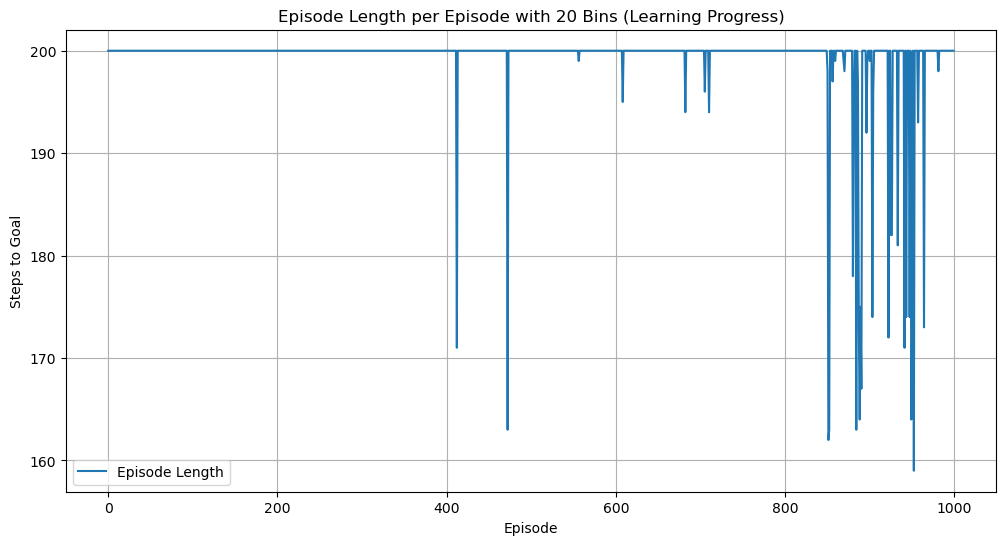

In [277]:
# Part - 3

def train_and_plot_episode_length_each_episode(env_name, q_class, bins, steps, total_episodes):
    env = gym.make(env_name, render_mode=None)
    disc = Discrete(env, bins)
    q = q_class(disc.size(), env.action_space.n)
    
    episode_lengths = []  # Store episode lengths over time

    for episode in tqdm(range(total_episodes)):
        observation, info = env.reset()
        state = disc.discretize(observation)
        step_count = 0

        while True:
            action = q.get_action(state)  # Choose action (epsilon-greedy)
            observation, reward, terminated, truncated, info = env.step(action)
            state2 = disc.discretize(observation)
            
            # Update the Q-table
            q.update(state, action, reward, state2)

            # Move to the next state
            state = state2
            step_count += 1

            # End episode if terminated or truncated
            if terminated or truncated:
                episode_lengths.append(step_count)
                break

    # Plotting episode length for each episode
    plt.figure(figsize=(12, 6))
    plt.plot(episode_lengths, label="Episode Length")
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title(f"Episode Length per Episode with {bins} Bins (Learning Progress)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Experimenting on MountainCar with a single discretization level and recording episode length
train_and_plot_episode_length_each_episode("MountainCar-v0", Q, bins=20, steps=1000000, total_episodes=1000)


In the above graph we can see that, episode length is decreasing as the model learning progresses. This is the evidence that the system is learning for Mountain Car environment.

100%|██████████| 500/500 [00:34<00:00, 14.64it/s]


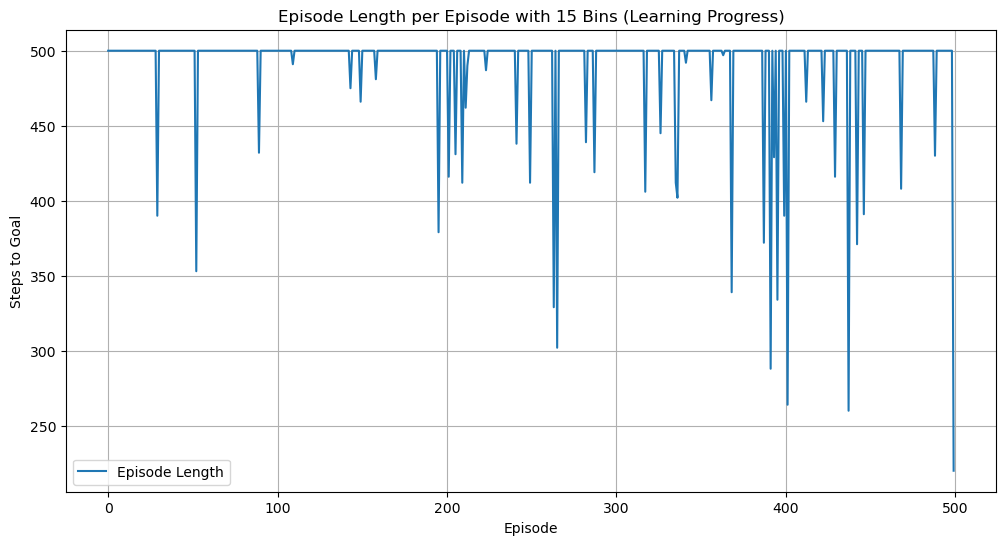

In [262]:
train_and_plot_episode_length_each_episode(ACROBOT, Q, bins=15, steps=1000000, total_episodes=500)

In the above graph we can see that, episode length is decreasing as the model learning progresses. This is the evidence that the system is learning for Acrobot environment.

100%|██████████| 1500/1500 [00:24<00:00, 61.56it/s]


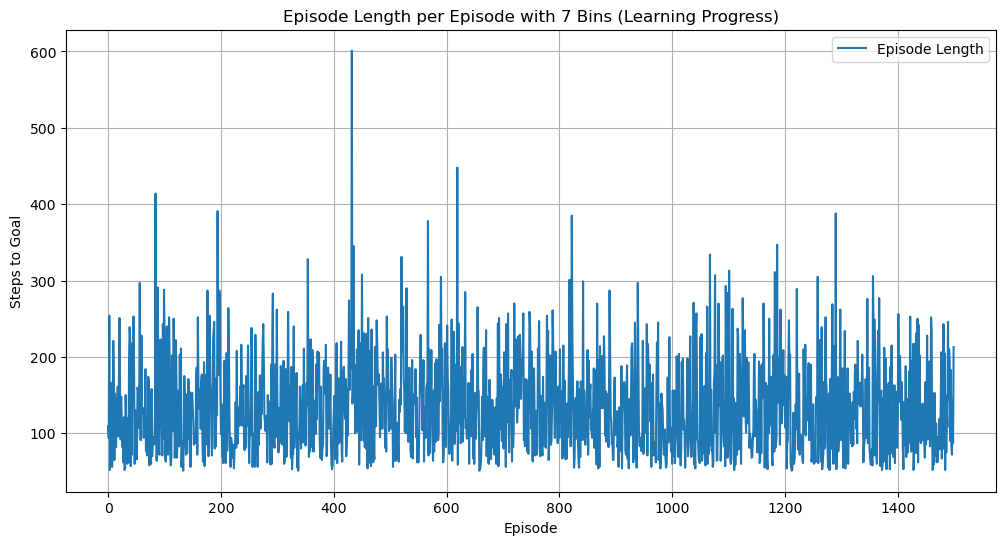

In [284]:
train_and_plot_episode_length_each_episode(LUNAR_LANDER, Q, bins=7, steps=1000000, total_episodes=1500)

In the above graph, we can see that the average episode length per 200 episode is decreasing as the model learning progresses. This is not an ideal situation, but, it shows some evidence that the system is learning for Lunar Landing environment.